## Import package

In [ ]:
import torch as t
import torch.nn as tnn
import torch.optim as toptim
import torch.nn.functional as tnf
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

## Define network

In [ ]:
class LeNet(tnn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = tnn.Conv2d(3, 6, 5)
        self.conv2 = tnn.Conv2d(6, 16, 5)
        self.fc1 = tnn.Linear(16*5*5, 120)
        self.fc2 = tnn.Linear(120, 84)
        self.fc3 = tnn.Linear(84, 10)
    
    def forward(self, x):
        x = tnf.max_pool2d(tnf.relu(self.conv1(x)), 2)
        x = tnf.max_pool2d(tnf.relu(self.conv2(x)), 2)
        x = t.flatten(x, 1) # flatten all dimension of image, except the batch dimension
        x = tnf.relu(self.fc1(x))
        x = tnf.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Create network

In [ ]:
net = LeNet()
print(net)

## List learnable parameter

In [ ]:
params = list(net.parameters())
print(len(params))
#print(params)
"""
params[0] = conv1 weight    params[2] = conv2 weight    params[4] = fc1 weight      params[6] = fc2 weight      params[8] = fc3 weight
params[1] = conv1 bias      params[3] = conv2 bias      params[5] = fc1 bias        params[7] = fc2 bias        params[9] = fc3 bias
"""
for p in params:
    print(p.size())

## Lets try random input

In [ ]:
img = t.randn(1, 1, 32, 32)
lbl = t.randn(10)
print("input data shape||", img.shape, lbl.shape)
lbl = lbl.view(1, -1) # change label to tensor like data with first dimension is batch size
out = net(img)
print("network output||", out.data)
print("output data shape||", out.data.shape, lbl.shape)
criterion = tnn.MSELoss()
loss = criterion(out, lbl)
print("target||", lbl)
print("loss||", loss.data)
print("loss manual||", t.mean((lbl.data-out.data)**2)) # calculate loss manually 


In [ ]:
# follow computational graph for loss
print(loss.grad_fn) # MSE loss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # Relu

### Try backprop

In [ ]:
# Backprop
net.zero_grad() # zero gradient for all parameters
print("conv1.bias.grad BEFORE backward")
print(net.conv1.bias.grad)

loss.backward()
print("conv1.bias.grad AFTER backward")
print(net.conv1.bias.grad)

### Try update weight

In [ ]:
# using torch optimizer
optimizer = toptim.SGD(net.parameters(), lr=0.01)

# should be in training loop
optimizer.zero_grad() # zero gradient buffers
out = net(img)
loss = criterion(out, lbl)
loss.backward()
"""
Update parameter is similar to:
lr = 0.01
for f in net.parameters():
    f.data.sub_(f.grad_data * lr)
"""
optimizer.step() # do update

## Prepare dataset

In [ ]:
train_data  = CIFAR10(
    root        = "data", 
    train       = True, 
    download    = True, 
    transform   = transforms.ToTensor()
)
test_data   = CIFAR10(
    root        = "data", 
    train       = False, 
    download    = True, 
    transform   = transforms.ToTensor()
)

In [ ]:
labels_map = {
    0: "airplane", 
    1: "automobile", 
    2: "bird", 
    3: "cat", 
    4: "deer", 
    5: "dog", 
    6: "frog", 
    7: "horse", 
    8: "ship", 
    9: "truck"
}

plt.rcParams["figure.figsize"] = (10,10)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = t.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(t.moveaxis(img,0,2)) # moveaxis from (C, H, W) format into (H, W, C) format
plt.show()

In [ ]:
# define batch size for training
batch_size = 1

# create data loader
train_dataloader    = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader     = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Training loss and optimizer

In [ ]:
criterion = tnn.MSELoss(reduction="sum")
optimizer = toptim.SGD(net.parameters(), lr=0.01)

## Train model

In [37]:
iteration = 5

for idx in range(iteration):
    print(f"Epoch #{idx}")
    total_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        imgs, targets = data
        # zero gradient the optimizer
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(imgs)
        # encode output to one-hot-encoding
        targets = tnf.one_hot(targets, 10).type(t.float)
        #print(outputs.dtype)
        #print(targets.dtype)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss += loss.item()
        if i % 10000 == 9999:    # print every 2000 mini-batches
            print('[%d, %5d] accumulated average loss: %.3f' %
                  (idx + 1, i + 1, total_loss / 10000))
            total_loss = 0.0

print('Finished Training')        


Epoch #0
[1, 10000] accumulated average loss: 0.625
[1, 20000] accumulated average loss: 0.633
[1, 30000] accumulated average loss: 0.626
[1, 40000] accumulated average loss: 0.626
[1, 50000] accumulated average loss: 0.625
Epoch #1
[2, 10000] accumulated average loss: 0.600
[2, 20000] accumulated average loss: 0.605
[2, 30000] accumulated average loss: 0.614
[2, 40000] accumulated average loss: 0.616
[2, 50000] accumulated average loss: 0.617
Epoch #2
[3, 10000] accumulated average loss: 0.586
[3, 20000] accumulated average loss: 0.602
[3, 30000] accumulated average loss: 0.599
[3, 40000] accumulated average loss: 0.593
[3, 50000] accumulated average loss: 0.601
Epoch #3
[4, 10000] accumulated average loss: 0.576
[4, 20000] accumulated average loss: 0.586
[4, 30000] accumulated average loss: 0.590
[4, 40000] accumulated average loss: 0.587
[4, 50000] accumulated average loss: 0.587
Epoch #4
[5, 10000] accumulated average loss: 0.563
[5, 20000] accumulated average loss: 0.568
[5, 30000

## Save trained model

In [38]:
PATH = "./model/cifar_lenet.pth"
t.save(net.state_dict(), PATH)

## Load saved model

In [39]:
trained_net = LeNet()
trained_net.load_state_dict(t.load(PATH))

<All keys matched successfully>

## Test model

ship


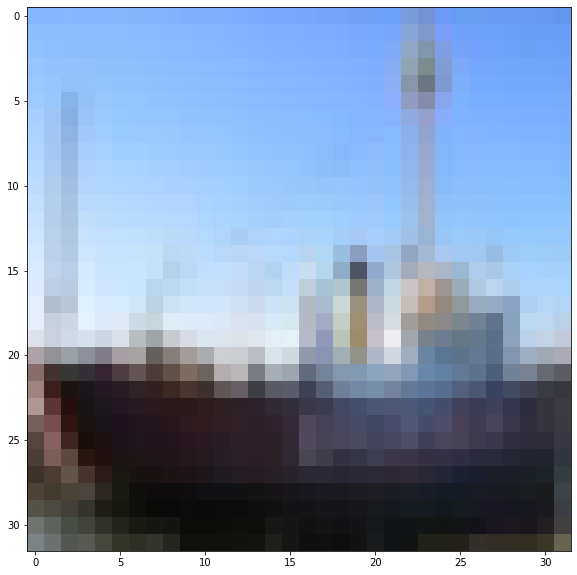

In [62]:
dataiter = iter(test_dataloader)
imgs, targets = dataiter.next()

# print images
plt.imshow(imgs.squeeze(0).moveaxis(0, 2))
print(labels_map[targets.item()])

In [63]:
outputs = trained_net(imgs)
_, predicted = t.max(outputs, 1)
print(labels_map[predicted.item()])

ship


In [68]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with t.no_grad():
    for data in test_dataloader:
        imgs, targets = data
        # calculate outputs by running images through the network
        outputs = net(imgs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = t.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [67]:
# test for whole dataset
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with t.no_grad():
    for data in test_dataloader:
        imgs, targets = data
        outputs = trained_net(imgs)
        _, predicted = t.max(outputs, 1)

        for label, prediction in zip(targets, predicted):
            if targets == predicted:
                correct_pred[classes[targets]] += 1
            total_pred[classes[targets]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:11s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane    is: 62.2 %
Accuracy for class automobile  is: 74.6 %
Accuracy for class bird        is: 40.2 %
Accuracy for class cat         is: 40.2 %
Accuracy for class deer        is: 46.2 %
Accuracy for class dog         is: 50.7 %
Accuracy for class frog        is: 61.5 %
Accuracy for class horse       is: 62.6 %
Accuracy for class ship        is: 71.7 %
Accuracy for class truck       is: 53.9 %


## Try to visualize what happen during testing of single image

In [84]:
params = list(trained_net.parameters())
for p in params:
    print(p.size())

print("accessed by instance variable")
print(trained_net.conv1.weight.size())
print(trained_net.conv1.bias.size())
print(trained_net.conv2.weight.size())
print(trained_net.conv2.bias.size())
print(trained_net.fc1.weight.size())
print(trained_net.fc1.bias.size())
print(trained_net.fc2.weight.size())
print(trained_net.fc2.bias.size())
print(trained_net.fc3.weight.size())
print(trained_net.fc3.bias.size())


torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
accessed by instance variable
torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [88]:
print(trained_net.conv1.bias)

Parameter containing:
tensor([ 8.8418e-01, -5.2058e-02,  3.8706e-01, -4.3971e-01,  1.1196e-03,
        -1.7866e+00], requires_grad=True)


In [89]:
print(params[1])

Parameter containing:
tensor([ 8.8418e-01, -5.2058e-02,  3.8706e-01, -4.3971e-01,  1.1196e-03,
        -1.7866e+00], requires_grad=True)


bird


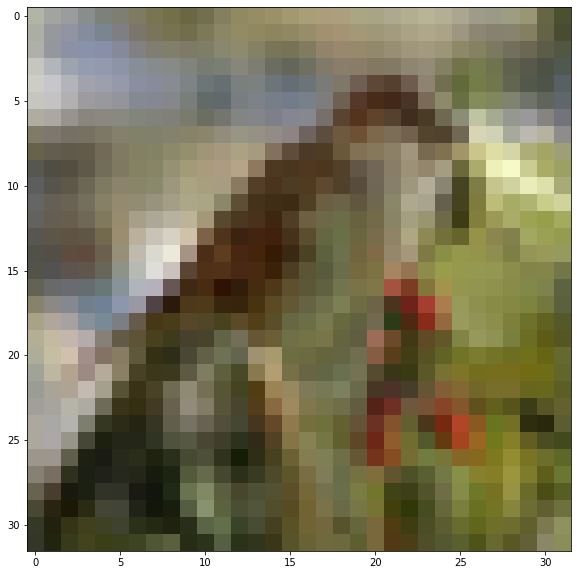

In [90]:
dataiter = iter(test_dataloader)
imgs, targets = dataiter.next()
plt.imshow(imgs.squeeze(0).moveaxis(0, 2))
print(labels_map[targets.item()])

### Conv1 output layer

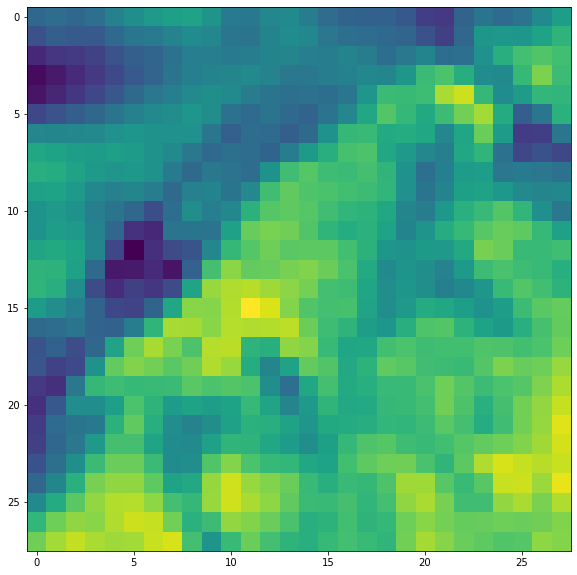

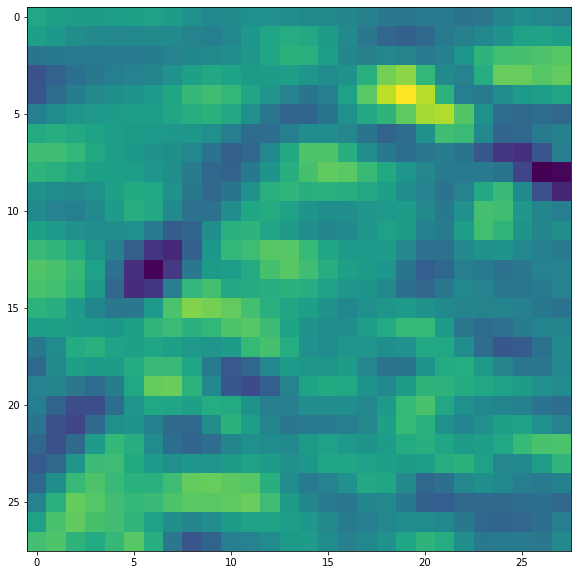

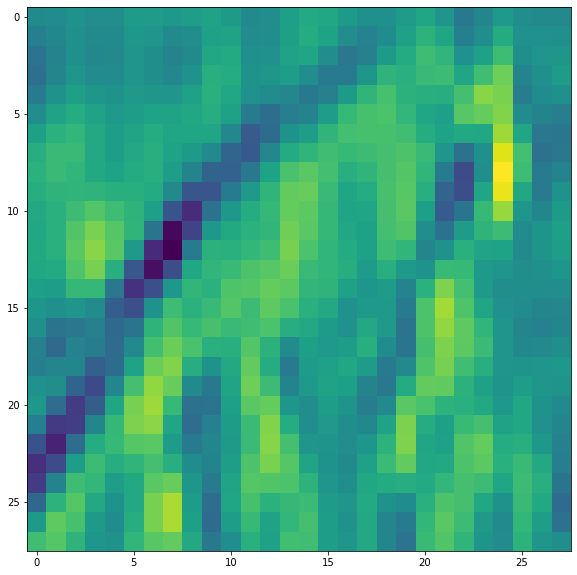

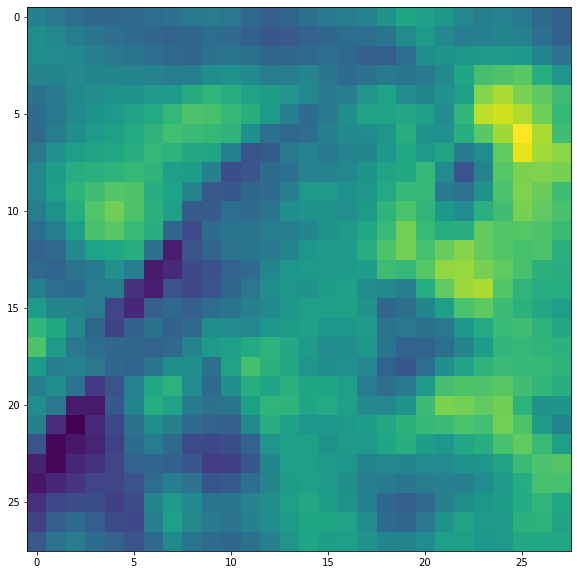

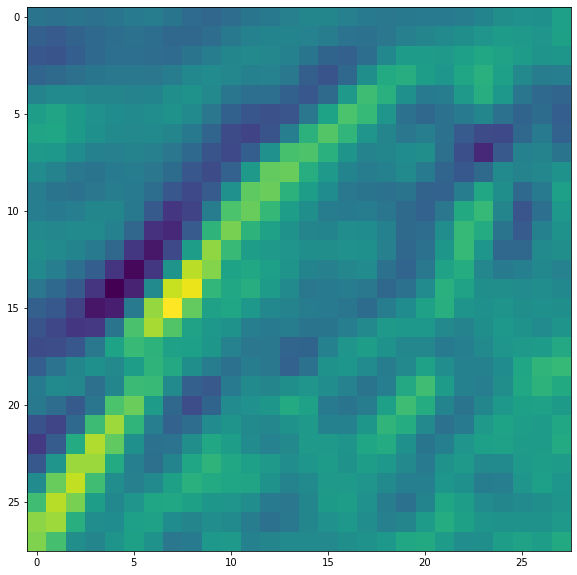

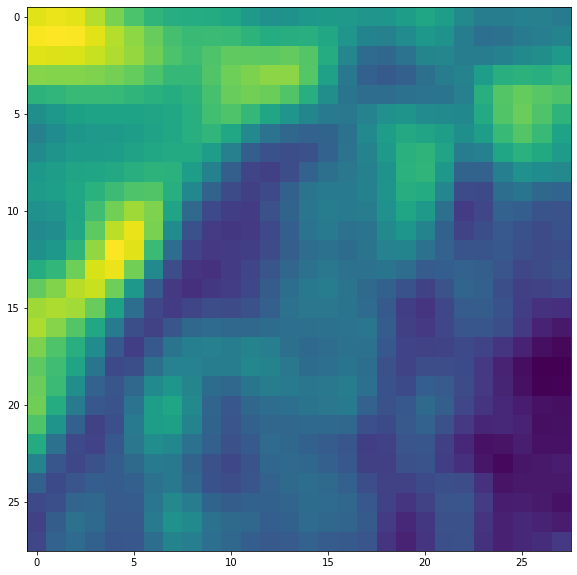

In [97]:
with t.no_grad():
    x = trained_net.conv1(imgs)
    # print each layer feature map
    for ch in range(x.shape[1]):
        plt.figure()
        plt.imshow(x[0,ch,:,:])

### Relu(Conv1) output

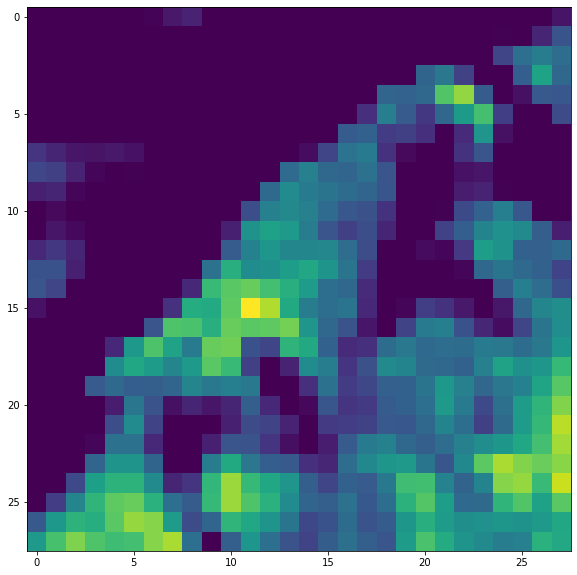

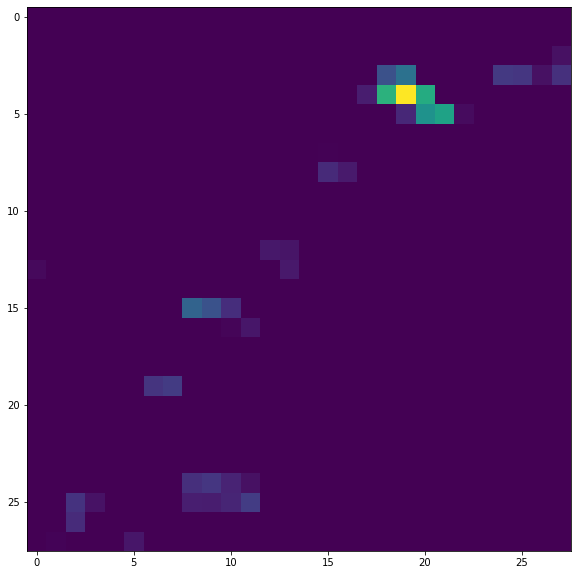

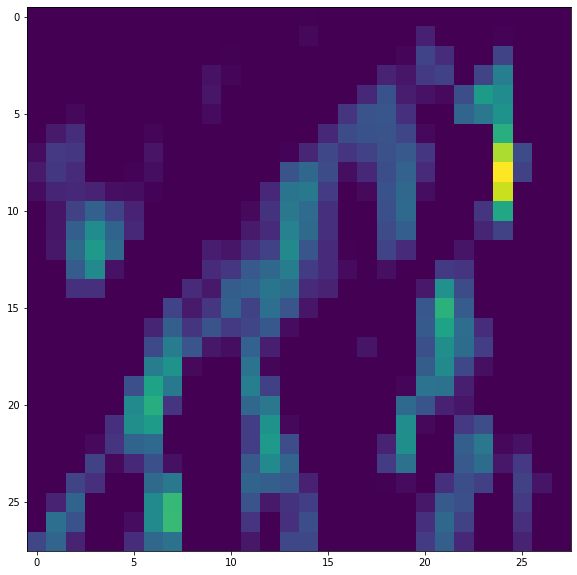

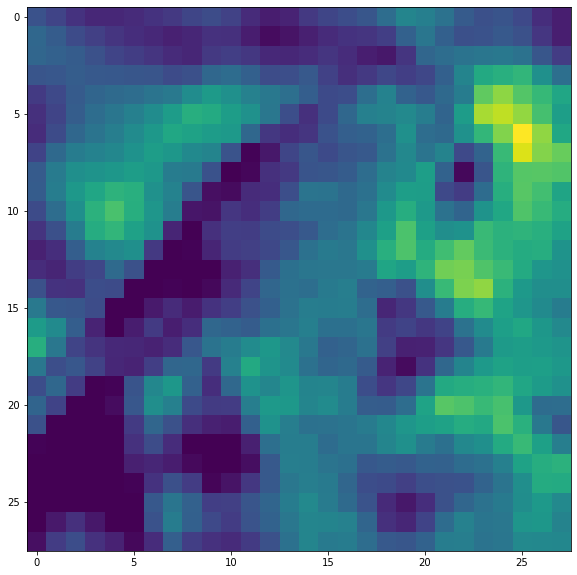

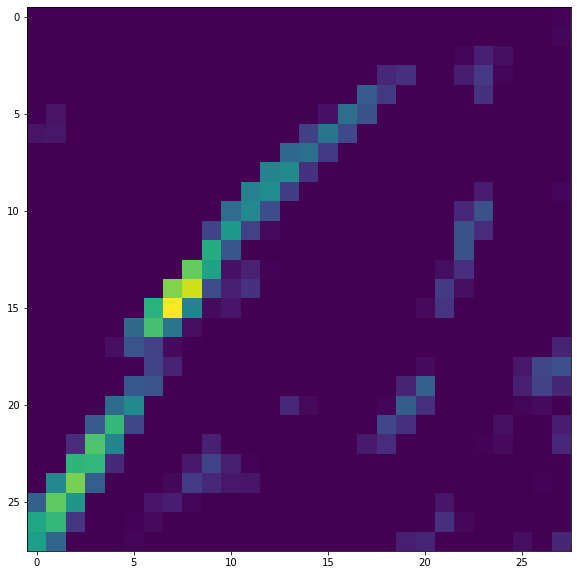

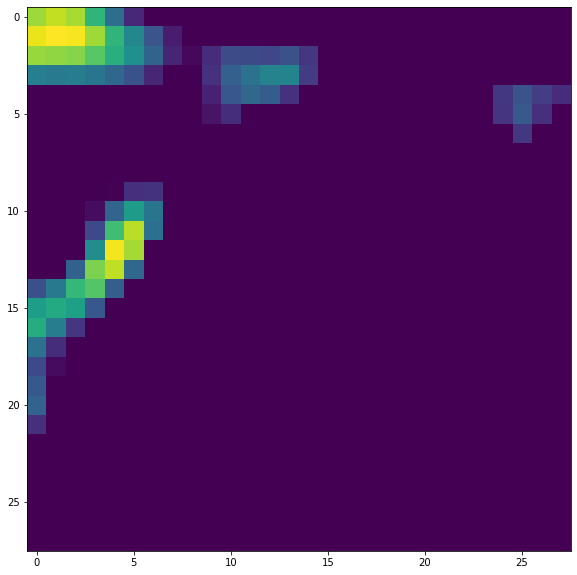

In [98]:
with t.no_grad():
    x = tnf.relu(x)
    # print each layer feature map
    for ch in range(x.shape[1]):
        plt.figure()
        plt.imshow(x[0,ch,:,:])

### Maxpool(Relu(Conv1)) output

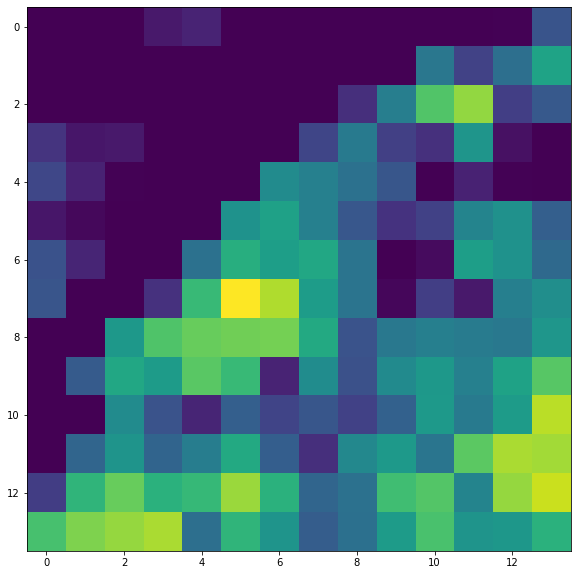

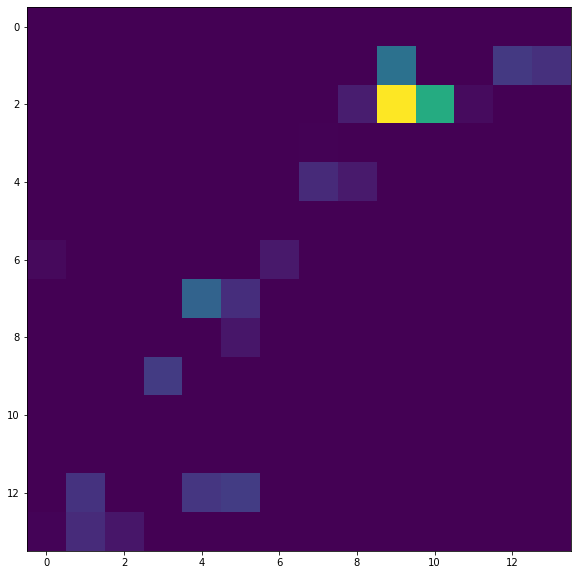

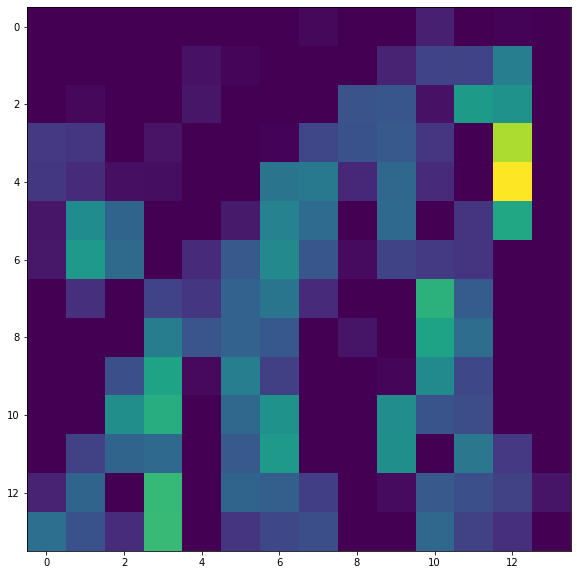

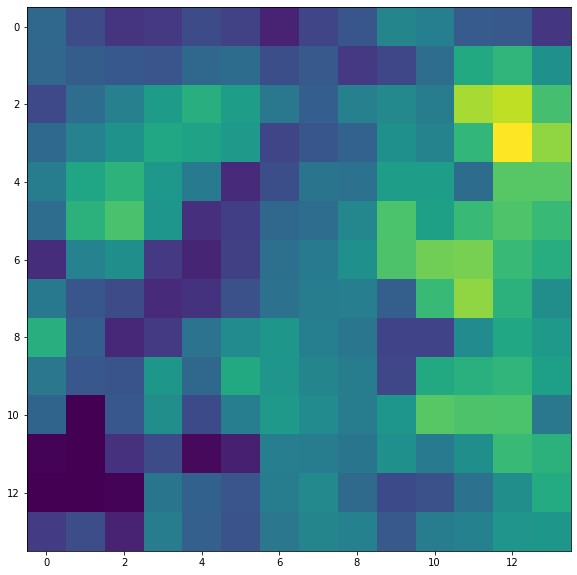

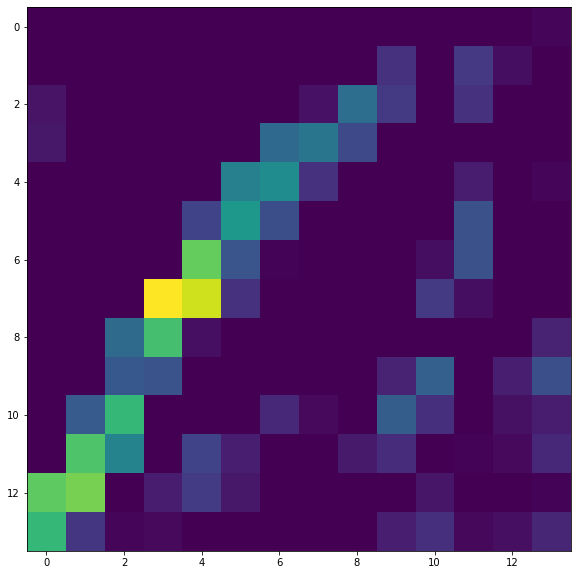

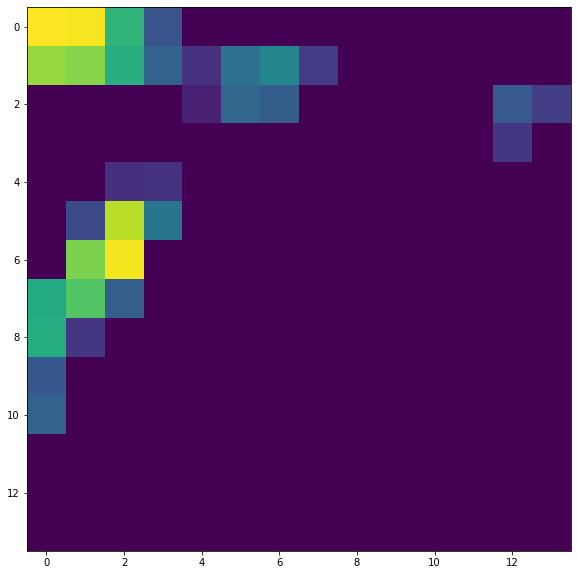

In [99]:
with t.no_grad():
    x = tnf.max_pool2d(x, 2)
    # print each layer feature map
    for ch in range(x.shape[1]):
        plt.figure()
        plt.imshow(x[0,ch,:,:])

### Conv2 output

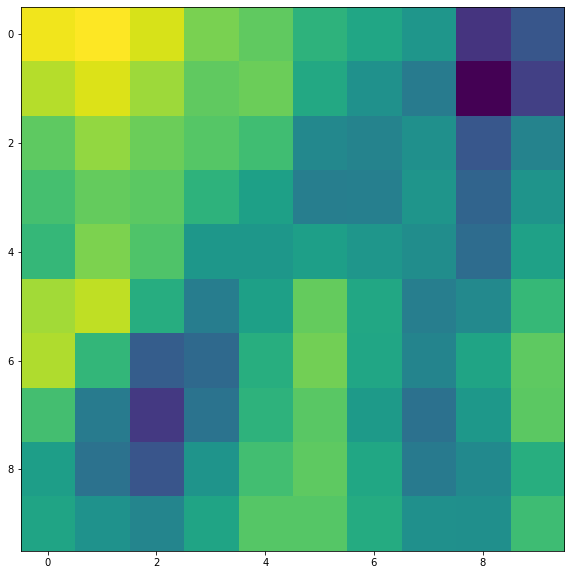

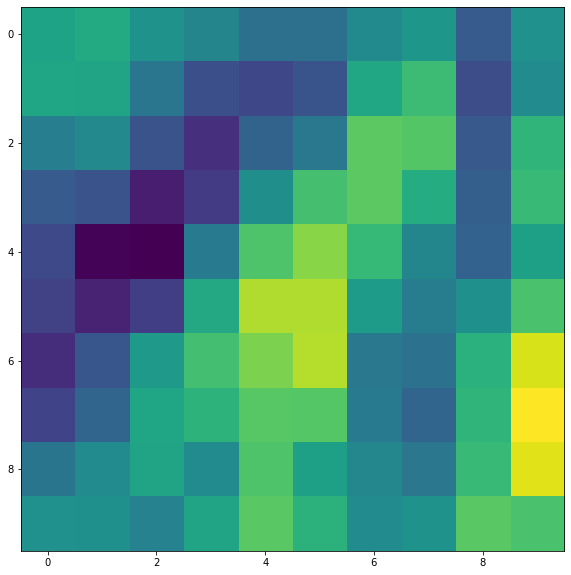

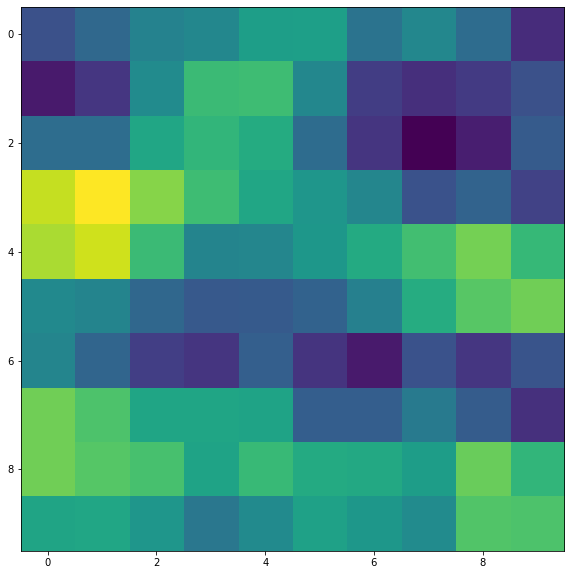

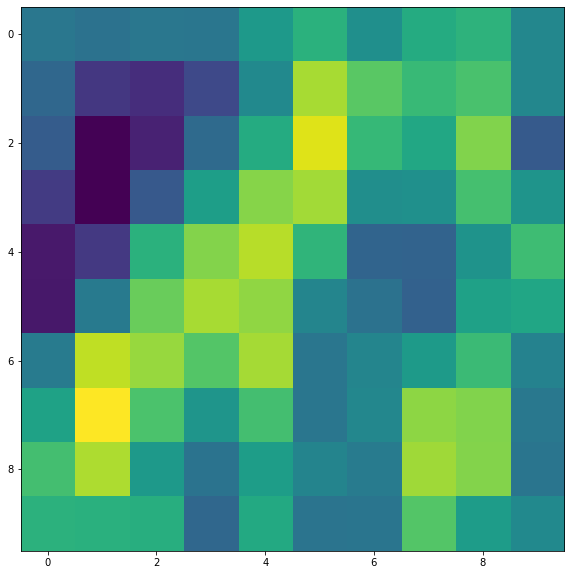

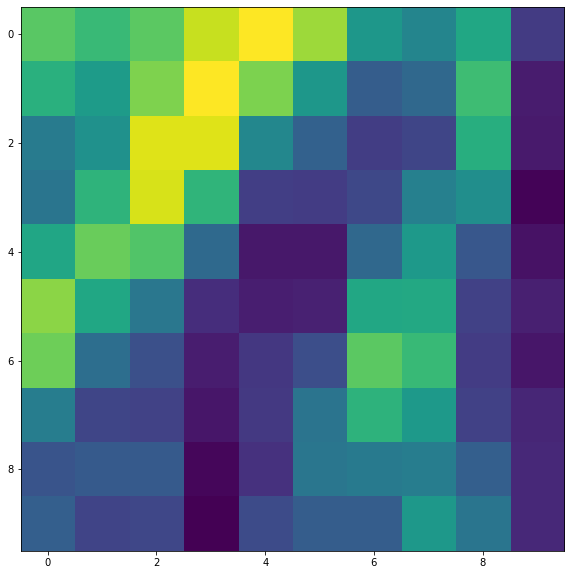

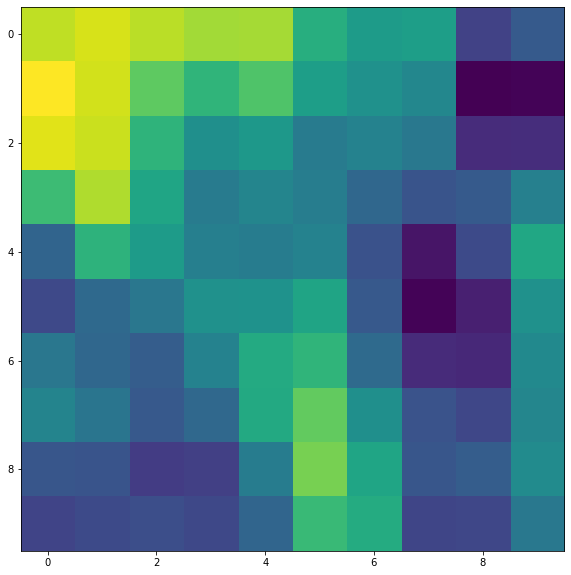

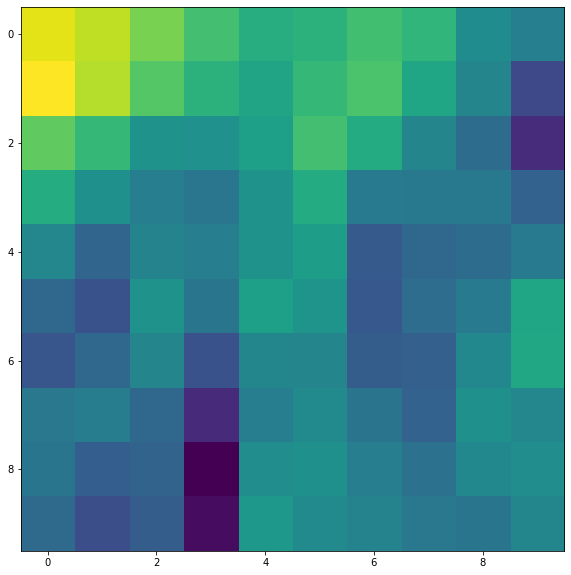

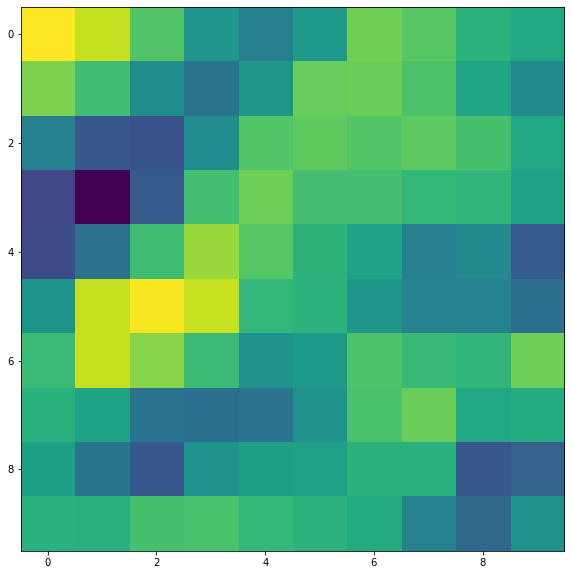

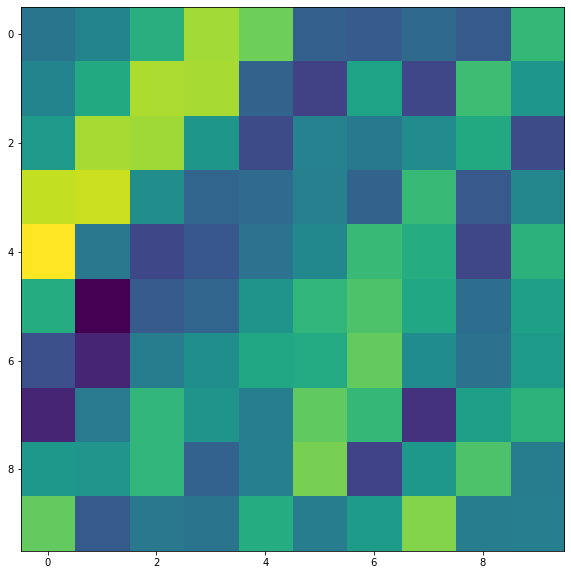

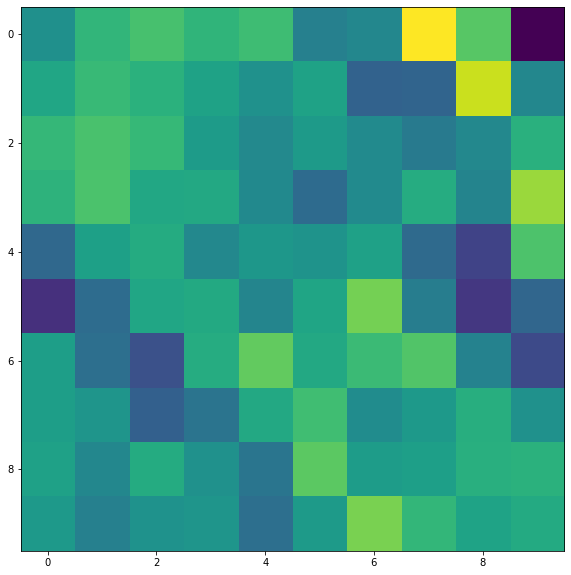

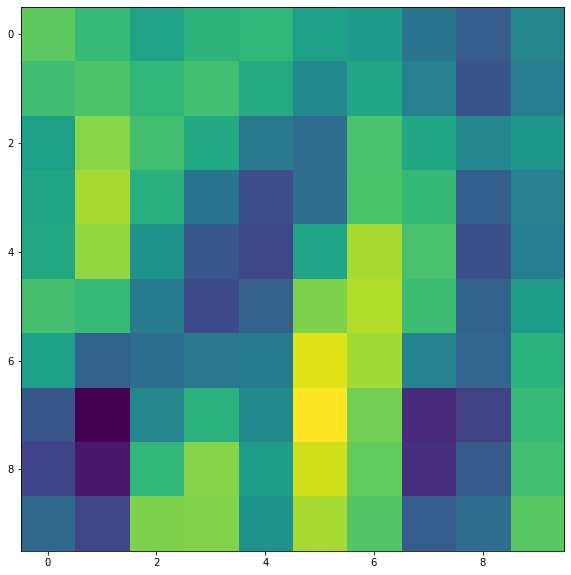

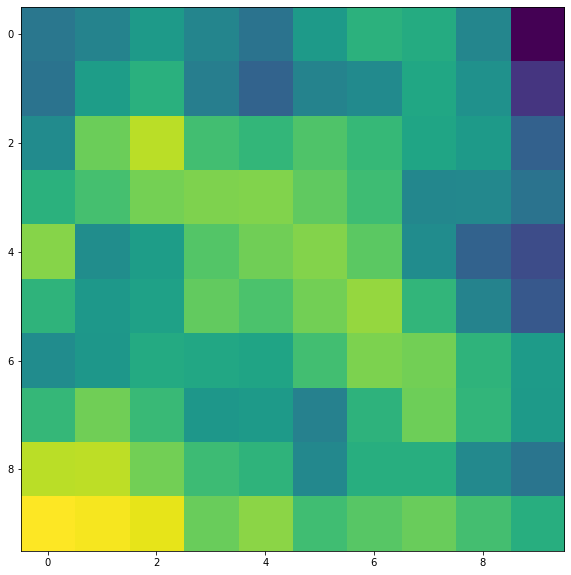

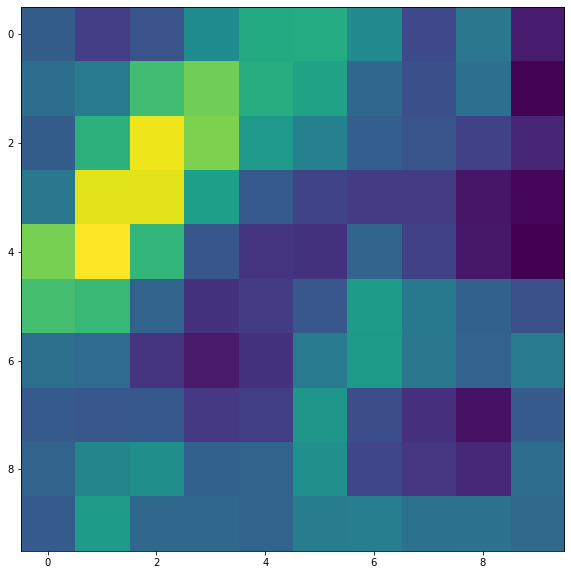

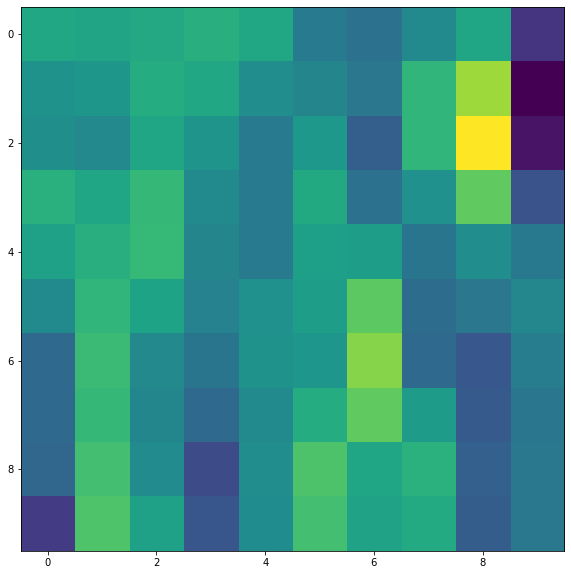

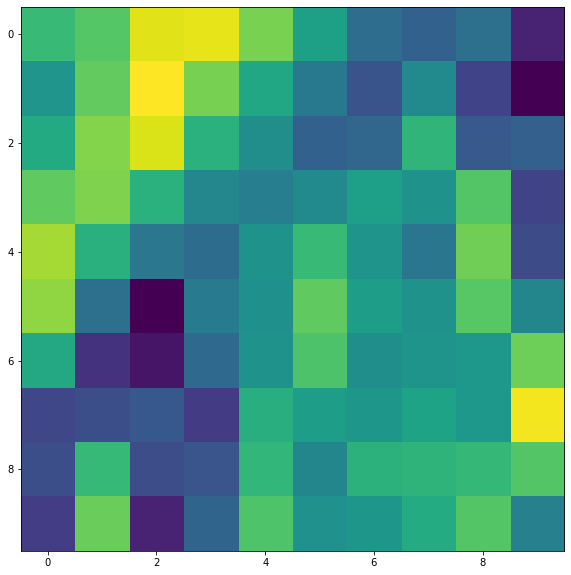

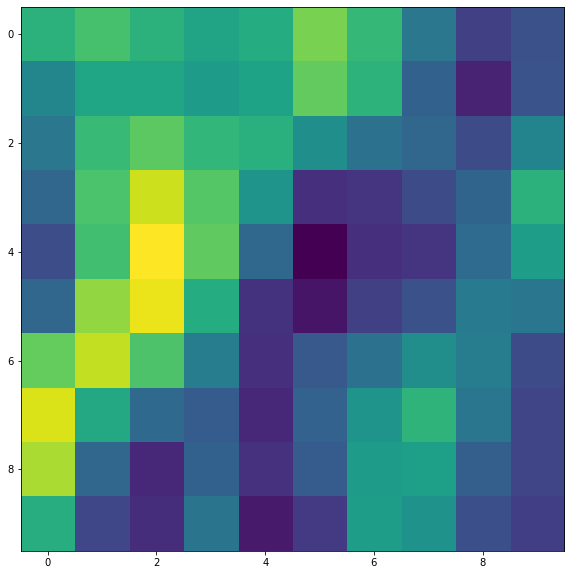

In [100]:
with t.no_grad():
    x = trained_net.conv2(x)
    # print each layer feature map
    for ch in range(x.shape[1]):
        plt.figure()
        plt.imshow(x[0,ch,:,:])

### Relu(Conv2) output

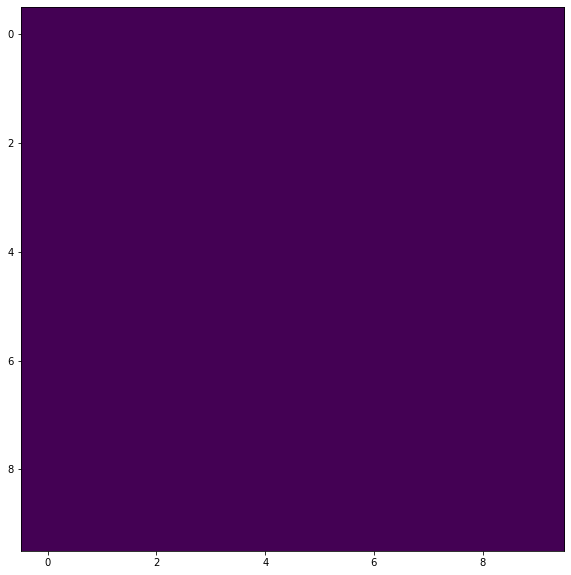

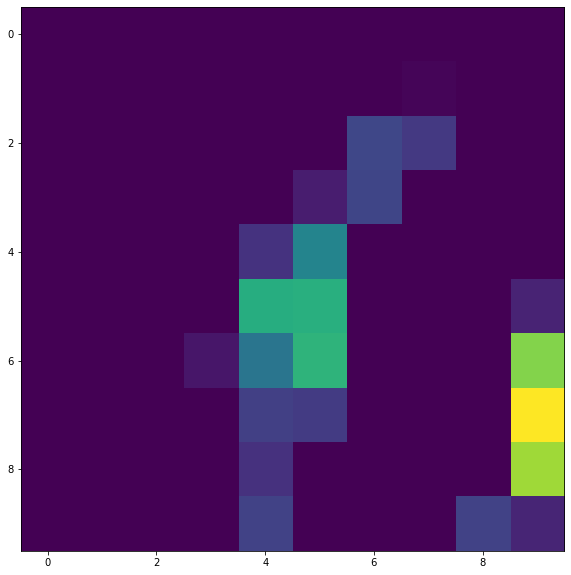

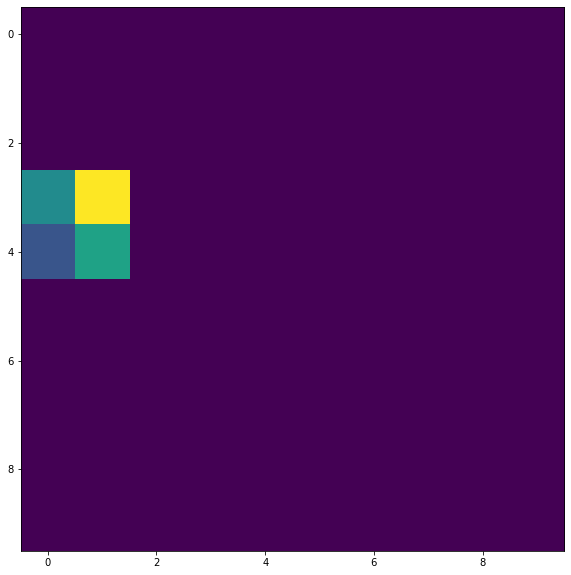

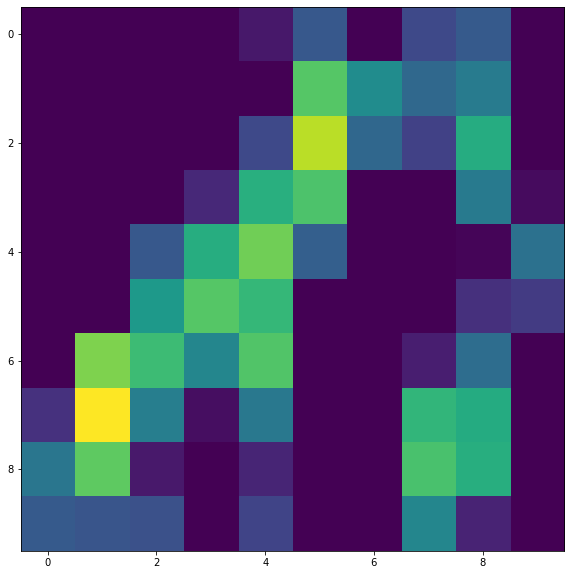

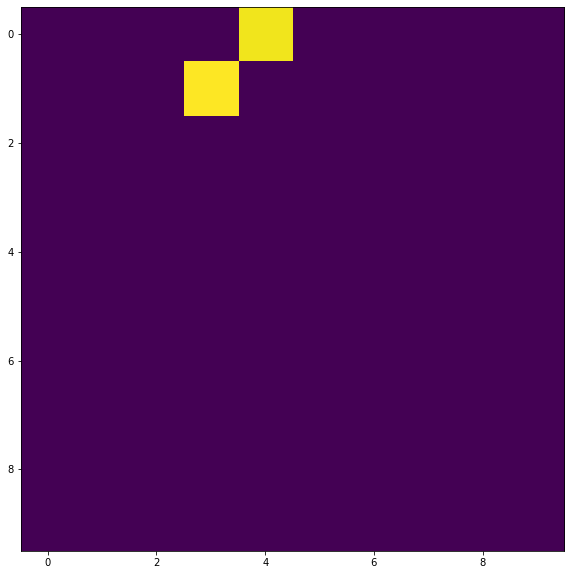

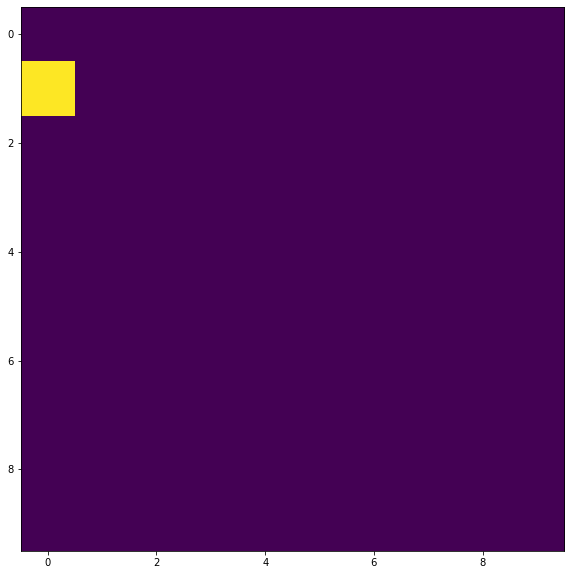

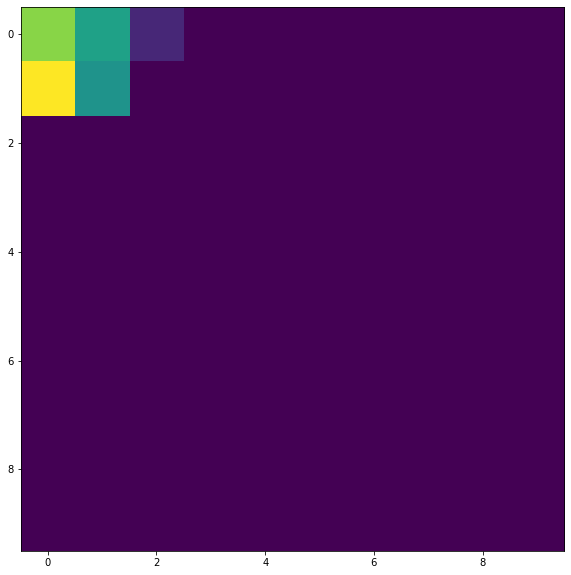

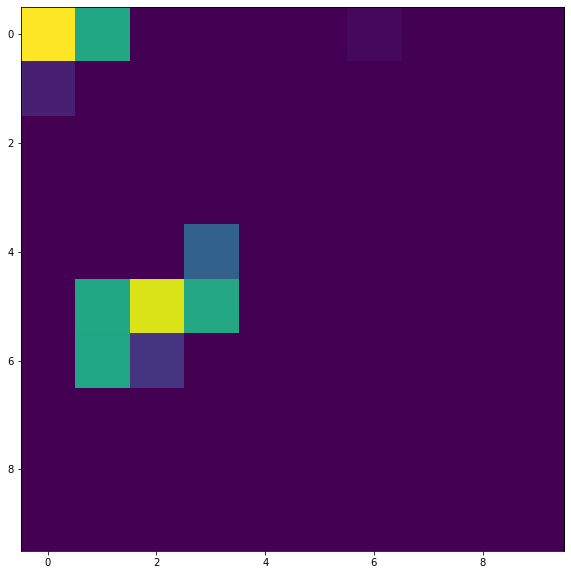

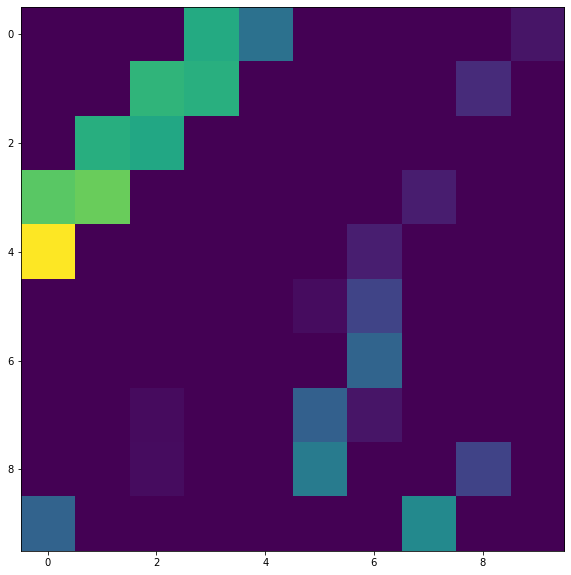

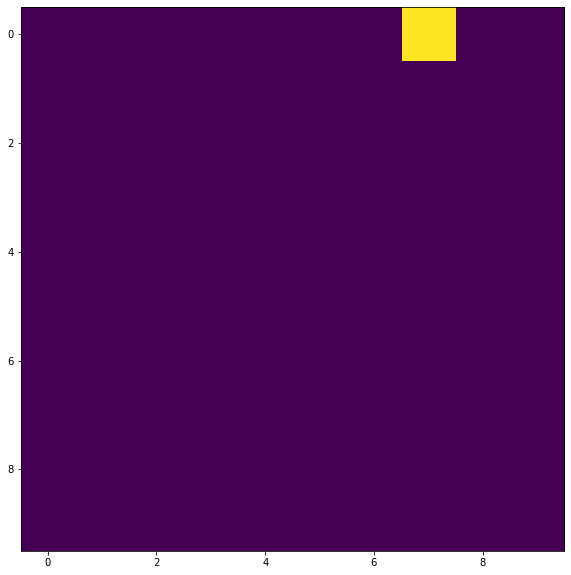

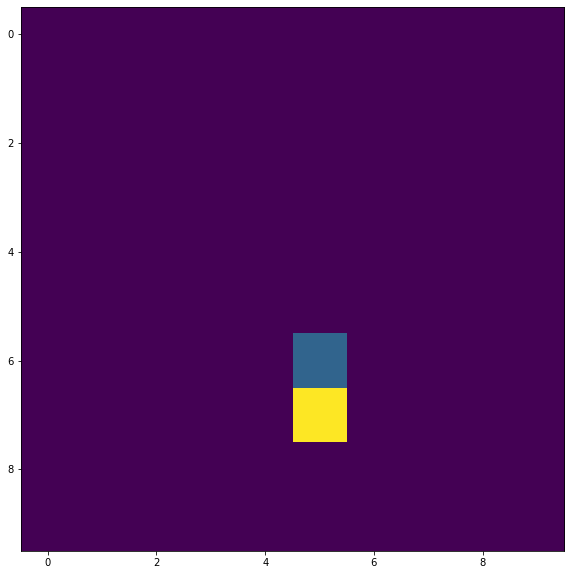

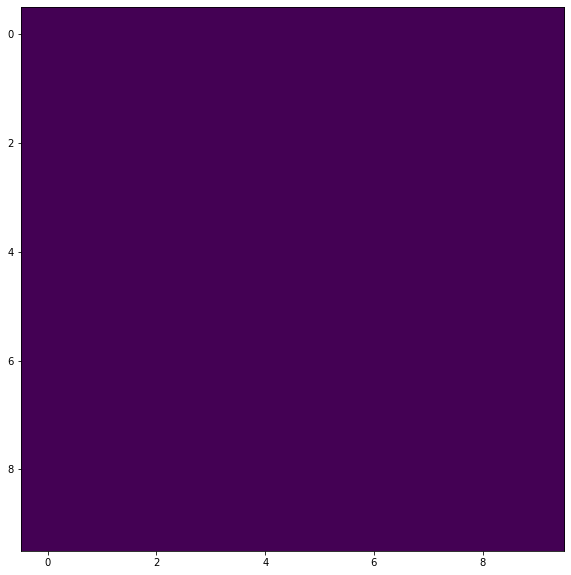

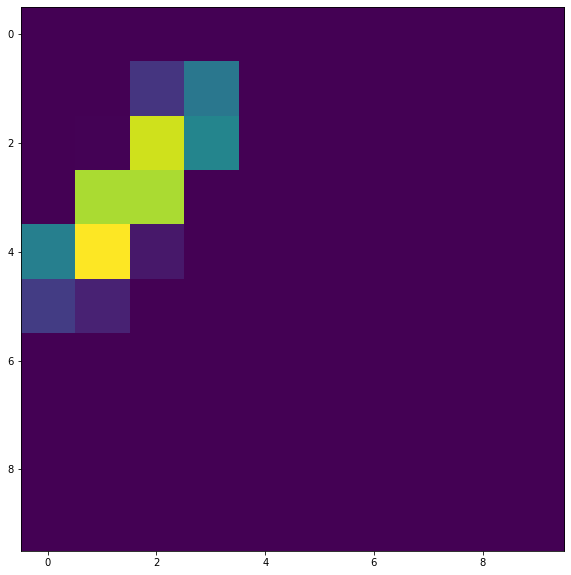

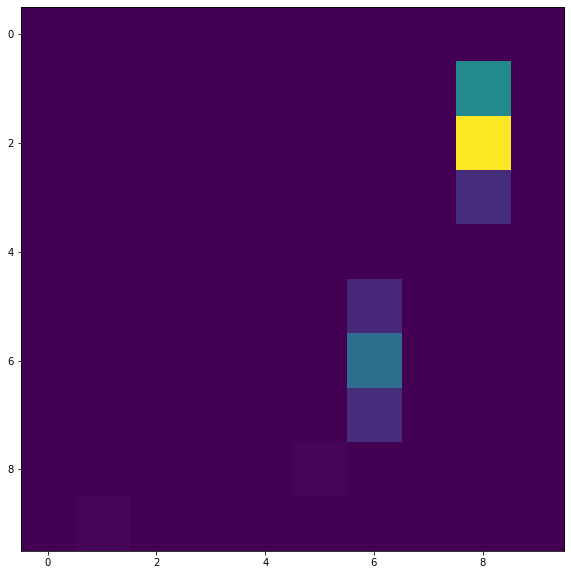

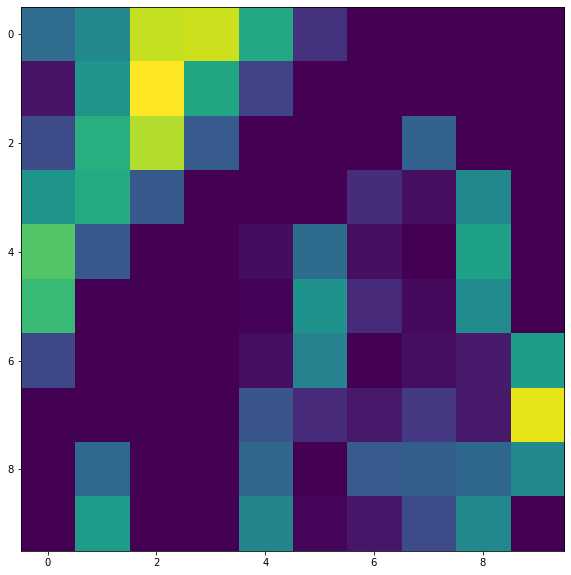

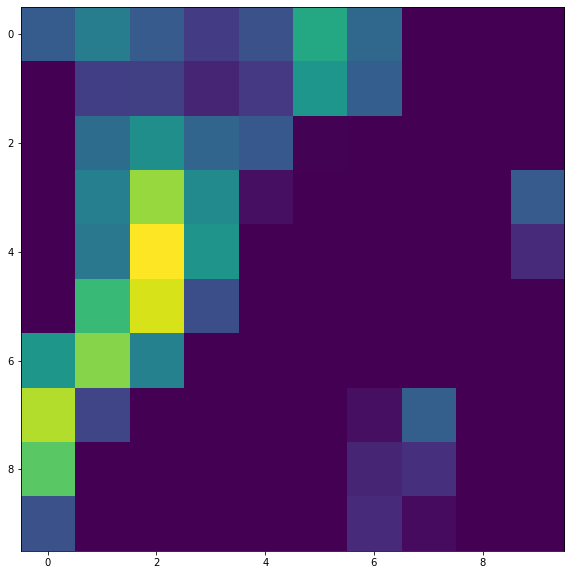

In [101]:
with t.no_grad():
    x = tnf.relu(x)
    # print each layer feature map
    for ch in range(x.shape[1]):
        plt.figure()
        plt.imshow(x[0,ch,:,:])

### Maxpool(Relu(Conv2)) output

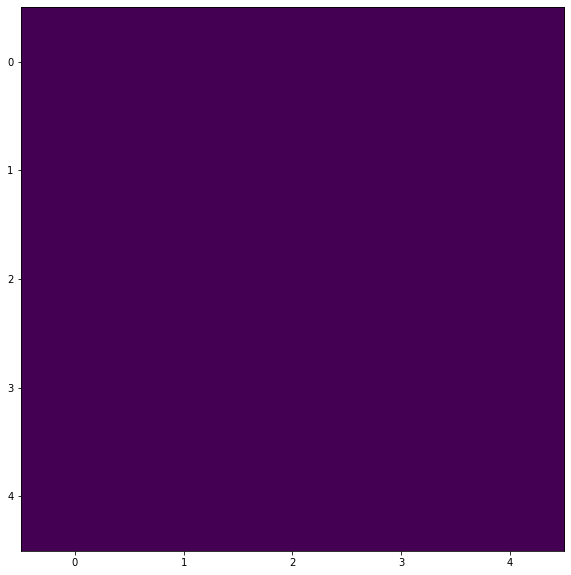

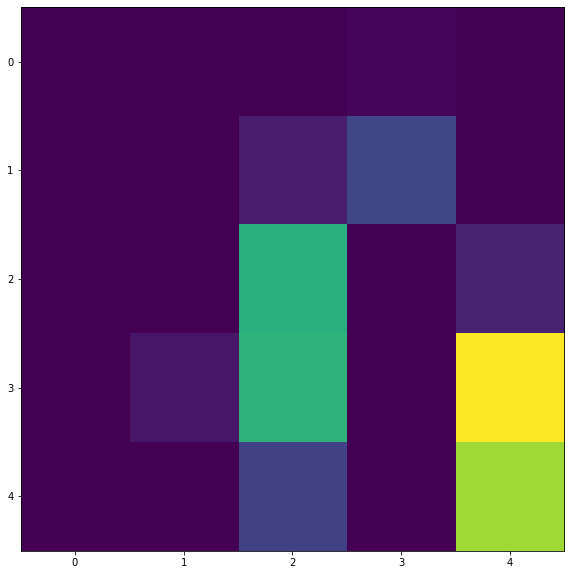

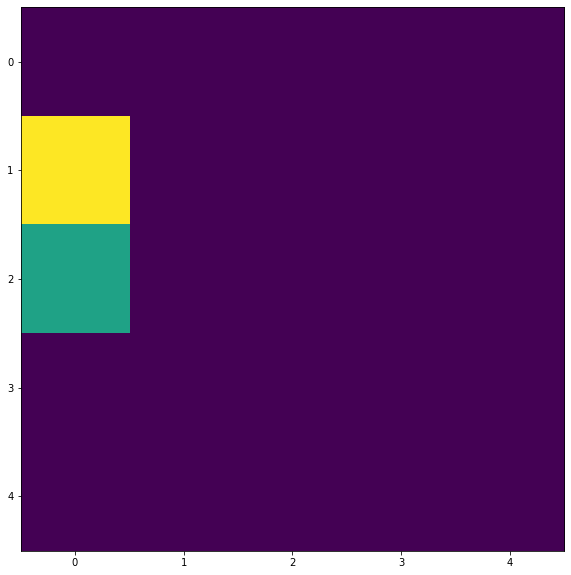

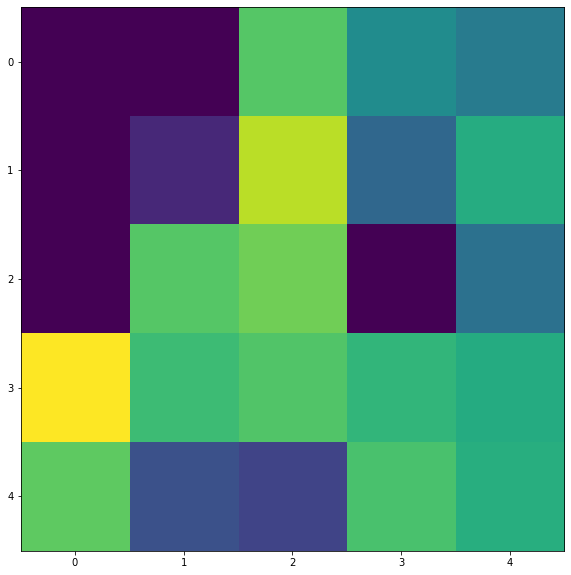

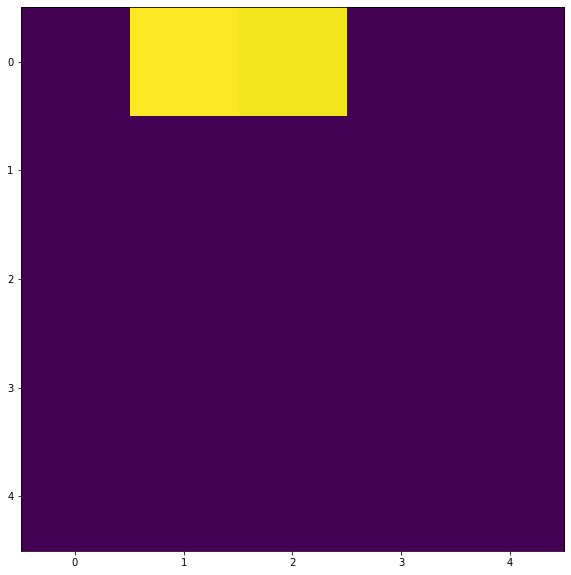

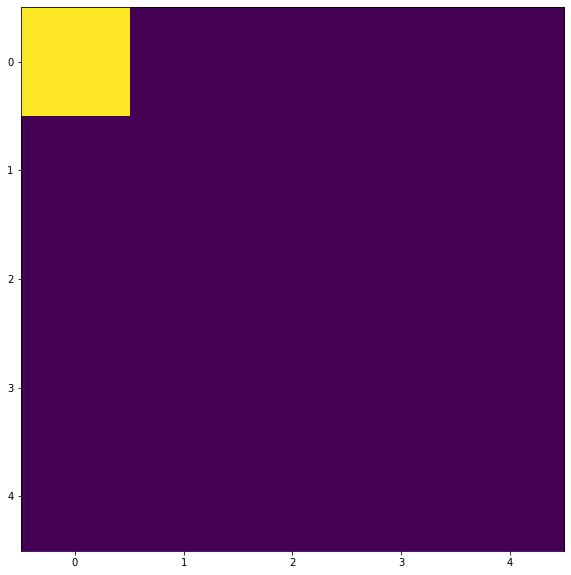

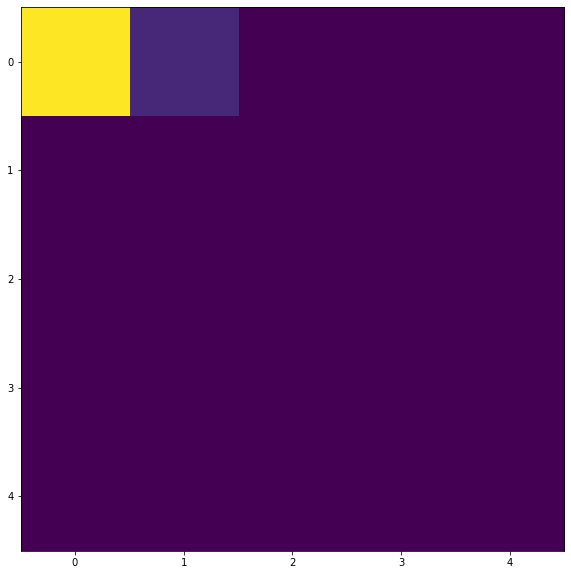

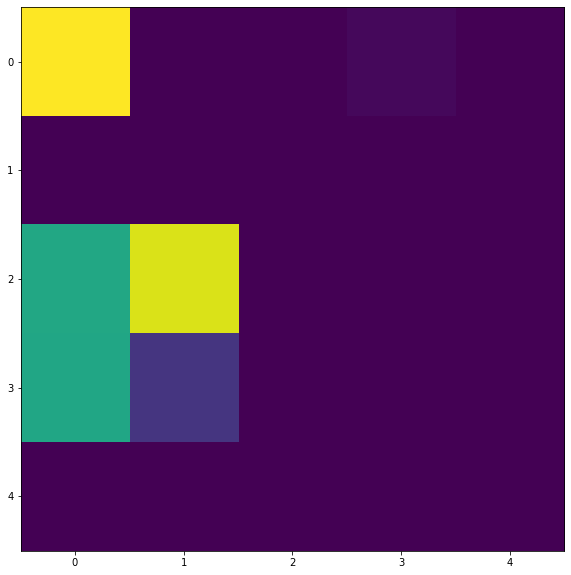

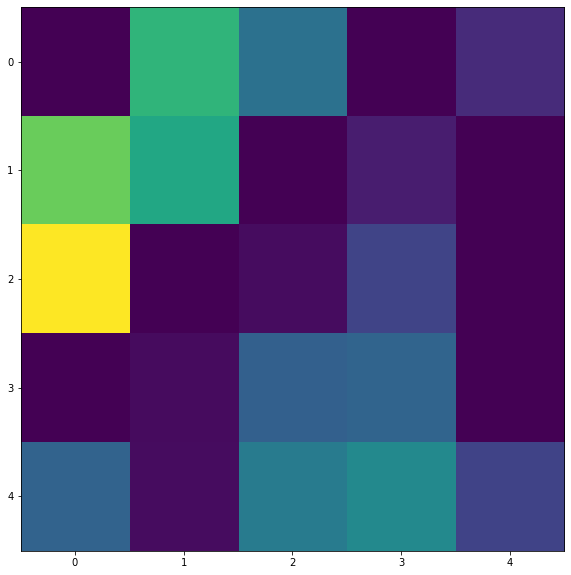

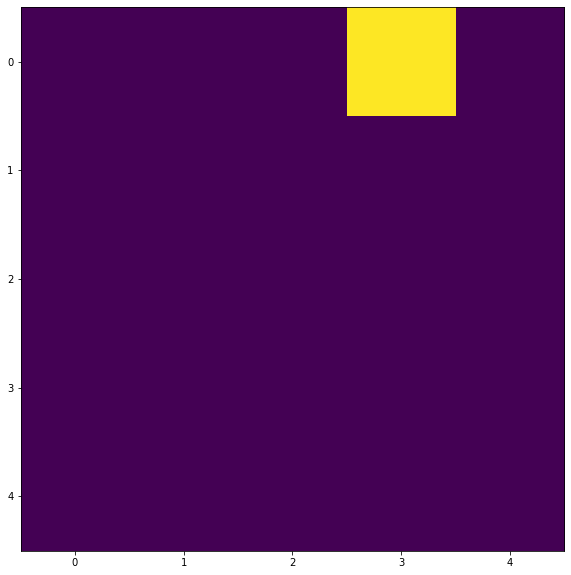

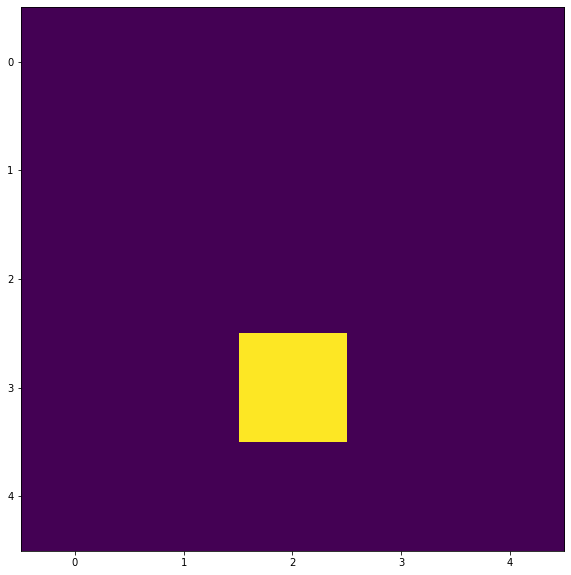

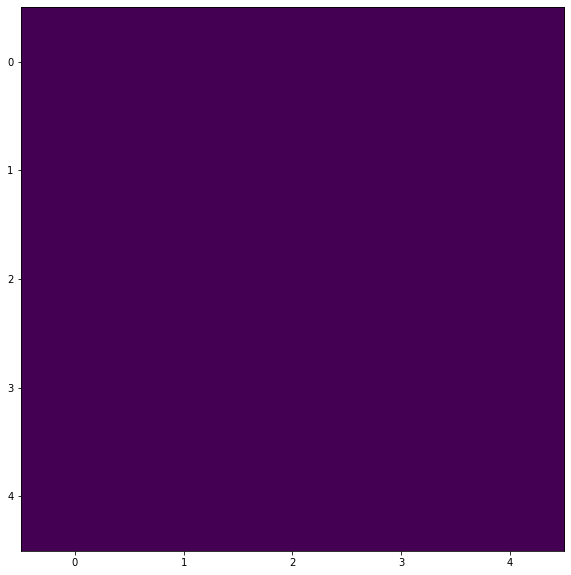

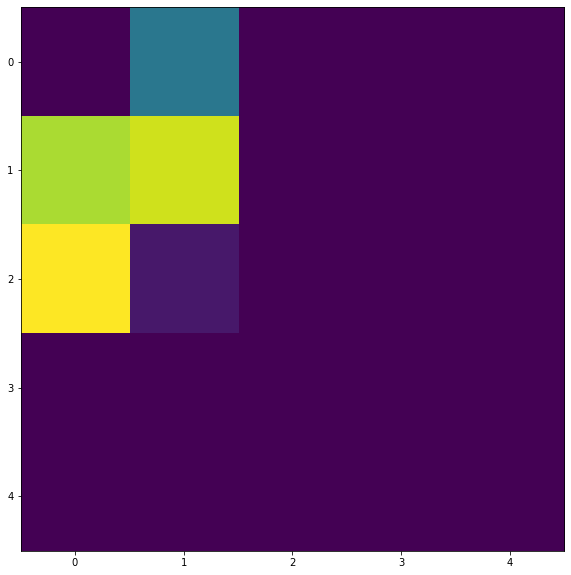

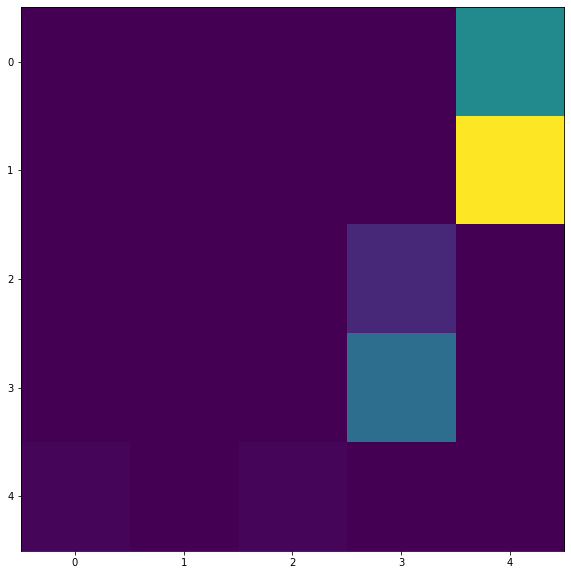

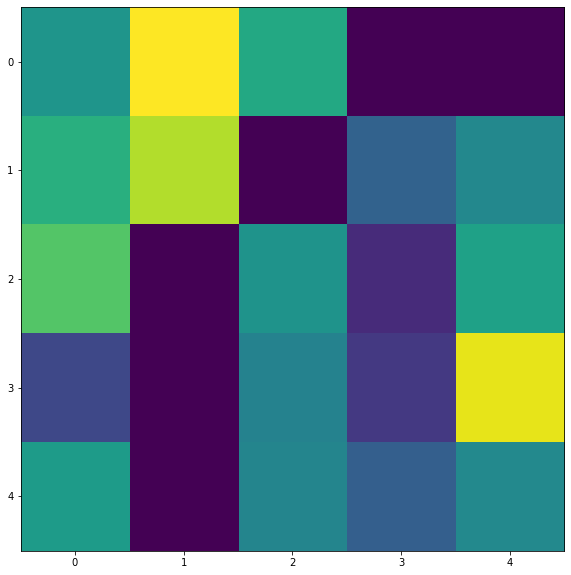

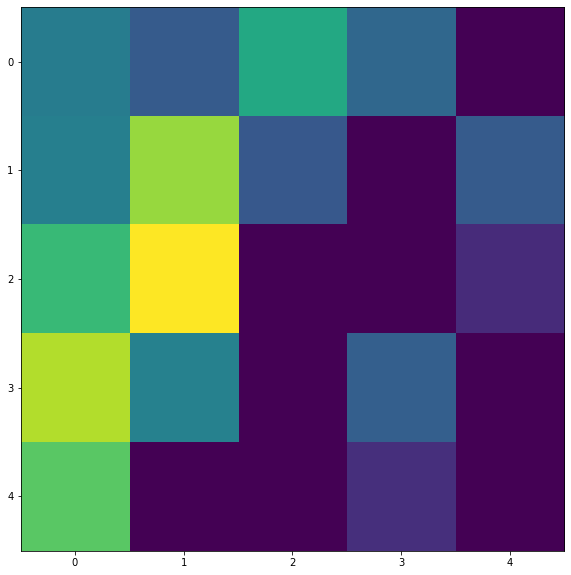

In [103]:
with t.no_grad():
    x = tnf.max_pool2d(x, 2)
    # print each layer feature map
    for ch in range(x.shape[1]):
        plt.figure()
        plt.imshow(x[0,ch,:,:])

### Flatten output

In [104]:
with t.no_grad():
    x = t.flatten(x, 1)
    print(x.shape)

torch.Size([1, 400])


### Relu(Fc1) output

In [105]:
with t.no_grad():
    x = tnf.relu(trained_net.fc1(x))
    print(x.shape)

torch.Size([1, 120])


### Relu(Fc2) output

In [106]:
with t.no_grad():
    x = tnf.relu(trained_net.fc2(x))
    print(x.shape)

torch.Size([1, 84])


### Fc3 output

In [107]:
with t.no_grad():
    x = trained_net.fc3(x)
    print(x.shape)
    print(x)

torch.Size([1, 10])
tensor([[0.1792, 0.0358, 0.2316, 0.1468, 0.0669, 0.1361, 0.0812, 0.0611, 0.0114,
         0.0507]])


### Get max class

In [112]:
_, predicted = t.max(x, 1)
print(predicted.item())
print(labels_map[predicted.item()])

print(classes)

2
bird
('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## Bounding boxes
On the next project